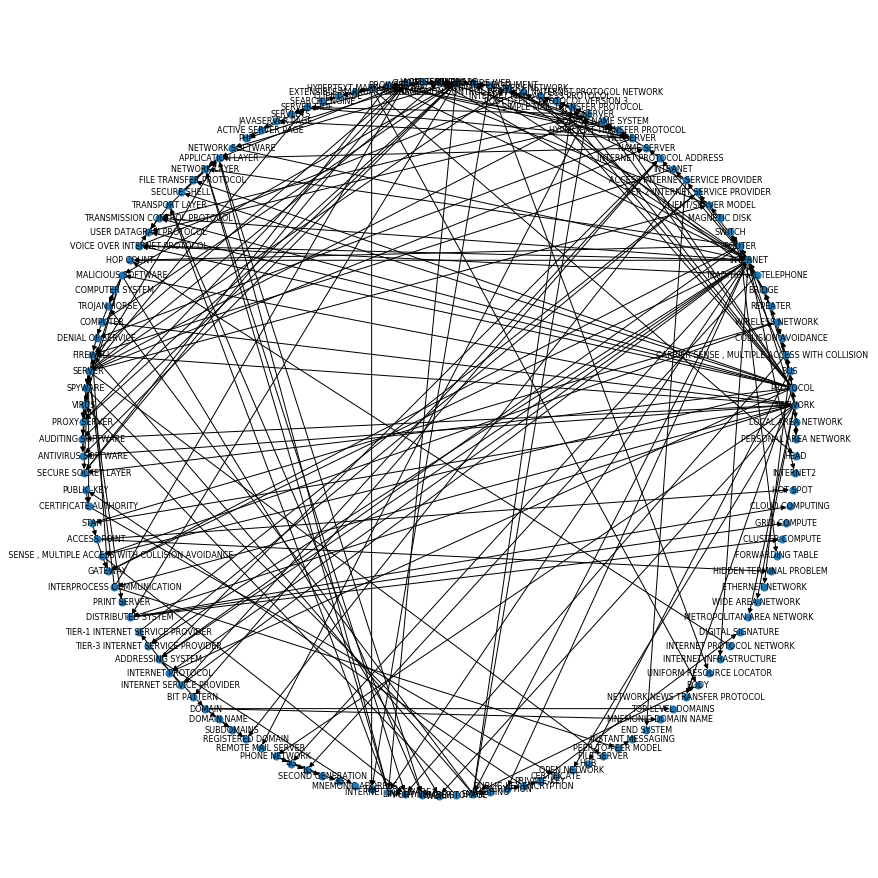

mirenda mirenda


UnboundLocalError: local variable 'conteggio' referenced before assignment

In [6]:
# da terminale: python2 computeAgreement_PRET.py > fileout.txt
import nltk
from nltk.metrics import agreement
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score
import random
import networkx
import matplotlib.pyplot as plt
# from statsmodels.stats.inter_rater import (fleiss_kappa, cohens_kappa,to_table, aggregate_raters)

# prima di eseguire questo script, nella cartella da terminale
# sed -i 's/ /_/g' ./*.json


import codecs
import os
import glob

extension = 'tab'
raters = []


def creaCoppieAnnot(rater1, rater2, term_pairs, pairs, term_pairs_tuple):
    coppieannot = {}
    conteggio = {"1,1": 0, "1,0": 0, "0,1": 0, "0,0": 0}
    for pair in pairs:
        # per ogni concept pair controllo fra le coppie E i paths di r1
        if pair in term_pairs[rater1] or check_trans(rater1, term_pairs_tuple, pair):
            # se presente, controllo fra coppie e paths di r2 e incremento i contatori
            if pair in term_pairs[rater2] or check_trans(rater2, term_pairs_tuple, pair):
                coppieannot[pair] = "1,1"
                conteggio["1,1"] += 2  # inv_pt1: scelgo di considerare le coppie inverse come both agree
                conteggio["0,0"] -= 2  # inv_pt2: compenso la scelta di tenenre conto le inverse in both agree
            # conteggio["1,1"]+=1 #no_inv: le coppie inverse valgolo come both diagree
            else:
                coppieannot[pair] = "1,0"
                conteggio["1,0"] += 1
            # altrimenti, se manca coppia e percorso in r1 e r2 o solo in r1, incrementa questi contatori
        elif pair not in term_pairs[rater1]:
            if pair not in term_pairs[rater2] and not check_trans(rater2, term_pairs_tuple, pair):
                coppieannot[pair] = "0,0"
                conteggio["0,0"] += 1
            else:
                coppieannot[pair] = "0,1"
                conteggio["0,1"] += 1
    return coppieannot, conteggio


def computeF1(conteggio):
    precision = conteggio["1,1"] / float(conteggio["0,1"] + conteggio["1,1"])
    recall = conteggio["1,1"] / float(conteggio["1,0"] + conteggio["1,1"])
    F1 = 2 * float(precision * recall) / float(precision + recall)
    return F1


def initialTerms():
    conceptst2k = []
    # concetti estratti automaticamente condivisi da tutti gli annotatori (file txt esterno) [terminologia iniziale]
    InputTerminology = codecs.open("new_terms.txt", "r", "utf-8").read()
    terminology = InputTerminology.split("\n")
    for concept in terminology:
        if concept:
            conceptst2k.append(concept.upper())
    return conceptst2k


'''def create_transitives(term_pairs_tuple):
    for rater, pairs in term_pairs_tuple.items():
        print(rater)
        g = networkx.DiGraph(pairs)
        for path in networkx.all_simple_paths(g, source="COMPUTER", target="GATEWAY"):
            print(path)'''


def check_trans(rater, term_pairs_tuple, pair):
    # print(pair)
    # print(rater2)
    g = networkx.DiGraph(term_pairs_tuple[rater])
    if pair.split("-")[0] in g and pair.split("-")[1] in g:
        if networkx.has_path(g, source=pair.split("-")[0], target=pair.split("-")[1]):
            return True
    else:
        return False


def combineTerms_noInverse(conceptst2k):
    all_combs = []
    # creo tutte le possibili coppie di concetti automatici
    for term in conceptst2k:
        for i in range(len(conceptst2k)):
            if term != conceptst2k[i]:
                combination = term + "-" + conceptst2k[i]
                all_combs.append(combination)
    return all_combs


def main():
    term_pairs = {}
    term_pairs_tuple = {}
    conceptst2k = initialTerms()
    all_combs = combineTerms_noInverse(conceptst2k)

    # per ogni file che contiene l'annotazione
    for file in glob.glob('*.{}'.format(extension)):
        name = os.path.splitext(os.path.basename(file))[0]
        # print "File: ", name
        raters.append(name)
        term_pairs[name] = []
        term_pairs_tuple[name] = []
        with open(file) as data_file:
            reader = data_file.read().split("\n")
            for line in reader:
                if line:
                    # line="BOOL	PREQ	TARGET	sent_id	weigth	agreem"
                    # line="FALSE	NETWORK	PERSONAL_AREA_NETWORK	9	strong	5"
                    lineS = line.split("\t")
                    concept_pair = lineS[1] + "-" + lineS[2]
                    tupla = (lineS[1], lineS[2])
                    term_pairs[name].append(concept_pair)
                    term_pairs_tuple[name].append(tupla)

        # print(term_pairs_tuple)
        for rater1 in raters:
            g = networkx.DiGraph(term_pairs_tuple[rater1])
            pos = networkx.circular_layout(g)
            plt.figure(1,figsize=(12,12))
            networkx.draw(g, pos, node_size=50, with_labels=True, font_size=8)
            plt.show()
            for rater2 in raters:
                if rater1 != rater2:
                    copppieannotate, conteggio = creaCoppieAnnot(rater1, rater2, term_pairs, all_combs, term_pairs_tuple)
                print(rater1, rater2)
                print("All agree\t" + str(conteggio["1,1"]))
                print("1st only\t" + str(conteggio["1,0"]))
                print("2nd only\t" + str(conteggio["0,1"]))
                print("All disag\t" + str(conteggio["0,0"]))
                print("F-score\t" + str(computeF1(conteggio)))
                print()


main()

